In [ ]:
! pip install -q kaggle

In [ ]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nimash23","key":"223d50f0a670de6fa5cb6a758930e18a"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download 'truthisneverlinear/bach-breast-cancer-histology-images'

100% 12.5G/12.5G [08:42<00:00, 38.4MB/s]
100% 12.5G/12.5G [08:42<00:00, 25.7MB/s]


In [ ]:
!unzip bach-breast-cancer-histology-images.zip 

Archive:  bach-breast-cancer-histology-images.zip
  inflating: ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/Benign/Thumbs.db  
  inflating: ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/Benign/b001.tif  
  inflating: ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/Benign/b002.tif  
  inflating: ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/Benign/b003.tif  
  inflating: ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/Benign/b004.tif  
  inflating: ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/Benign/b005.tif  
  inflating: ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/Benign/b006.tif  
  inflating: ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/Benign/b007.tif  
  inflating: ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/Benign/b008.tif  
  inflating: ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/Benign/b009.tif  
  inflating: ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, random_split
from torchvision import datasets, transforms

import os

from PIL import Image

import torch.nn as nn
import torch.optim as optim

from torch.utils.data import random_split

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class ImageLoader(Dataset):
    def __init__(self, dir_path, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, class_dir in enumerate(sorted(os.listdir(dir_path))):
            class_dir_path = os.path.join(dir_path, class_dir)
            if os.path.isdir(class_dir_path):
                for filename in os.listdir(class_dir_path):
                    if filename.endswith('.tif'):
                        self.image_paths.append(os.path.join(class_dir_path, filename))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [ ]:
# Load data
transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
ls

bach-breast-cancer-histology-images.zip  kaggle.json
ICIAR2018_BACH_Challenge/                sample_data/
ICIAR2018_BACH_Challenge_TestDataset/


In [ ]:
dataset = ImageLoader(dir_path='ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos', transform=transform)

In [ ]:
classes = []

In [ ]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into training, validation, and test sets
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
# Get a batch of images from the data loader
images, labels = next(iter(train_loader))

# Check the size of the first image in the batch
image_size = images[0].size()
print("Image size:", image_size)

Image size: torch.Size([3, 32, 32])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.attention = AttentionBlock(out_channels)
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.attention(out)  # Apply attention block
        out += identity
        out = self.relu(out)
        return out



In [ ]:
# Define Attention Block
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // 4),
            nn.ReLU(inplace=True),
            nn.Linear(channels // 4, channels),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

In [ ]:
# Define ResNet model
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 3)
        # self.layer2 = self.make_layer(128, 4, stride=2)
        # self.layer3 = self.make_layer(256, 6, stride=2)
        # self.layer4 = self.make_layer(512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)
    
    def make_layer(self, channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(self.in_channels, channels))
        self.in_channels = channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(channels, channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        # out = self.layer2(out)
        # out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
model = ResNet(4).to(device)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

num_epochs = 50  # Set this to the number of epochs you want to train for

accuracy_values = []
precision_values = np.zeros((4, num_epochs))
recall_values = np.zeros((4, num_epochs))
f1_values = np.zeros((4, num_epochs))

best_metric = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation for each epoch
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []
    with torch.no_grad():  # No need to calculate gradients when evaluating
        for batch_idx, (data, targets_batch) in enumerate(valid_loader):
            data = data.to(device)
            targets_batch = targets_batch.to(device)

            scores = model(data)
            _, batch_predictions = scores.max(1)

            predictions.extend(batch_predictions.cpu().tolist())
            true_labels.extend(targets_batch.cpu().tolist())

    # Calculate metrics for each class
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average=None)
    recall = recall_score(true_labels, predictions, average=None)
    f1 = f1_score(true_labels, predictions, average=None)

    # Print metrics for each class
    for class_idx in range(4):
        print(f'Epoch [{epoch+1}/{num_epochs}], Class {class_idx}: Accuracy: {accuracy:.4f}, Precision: {precision[class_idx]:.4f}, Recall: {recall[class_idx]:.4f}, F1-Score: {f1[class_idx]:.4f}')

    if accuracy > best_metric:
        best_metric = accuracy
        best_model_state = model.state_dict()


    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average=None)
    recall = recall_score(true_labels, predictions, average=None)
    f1 = f1_score(true_labels, predictions, average=None)

    # Store metric values
    accuracy_values.append(accuracy)
    precision_values[:, epoch] = precision
    recall_values[:, epoch] = recall
    f1_values[:, epoch] = f1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/50], Class 0: Accuracy: 0.3125, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch [1/50], Class 1: Accuracy: 0.3125, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch [1/50], Class 2: Accuracy: 0.3125, Precision: 0.3125, Recall: 1.0000, F1-Score: 0.4762
Epoch [1/50], Class 3: Accuracy: 0.3125, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/50], Class 0: Accuracy: 0.3125, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch [2/50], Class 1: Accuracy: 0.3125, Precision: 0.0909, Recall: 0.0556, F1-Score: 0.0690
Epoch [2/50], Class 2: Accuracy: 0.3125, Precision: 0.3478, Recall: 0.9600, F1-Score: 0.5106
Epoch [2/50], Class 3: Accuracy: 0.3125, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/50], Class 0: Accuracy: 0.3250, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch [3/50], Class 1: Accuracy: 0.3250, Precision: 0.1250, Recall: 0.0556, F1-Score: 0.0769
Epoch [3/50], Class 2: Accuracy: 0.3250, Precision: 0.3472, Recall: 1.0000, F1-Score: 0.5155
Epoch [3/50], Class 3: Accuracy: 0.3250, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/50], Class 0: Accuracy: 0.4125, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch [4/50], Class 1: Accuracy: 0.4125, Precision: 0.4000, Recall: 0.1111, F1-Score: 0.1739
Epoch [4/50], Class 2: Accuracy: 0.4125, Precision: 0.3906, Recall: 1.0000, F1-Score: 0.5618
Epoch [4/50], Class 3: Accuracy: 0.4125, Precision: 0.5455, Recall: 0.3333, F1-Score: 0.4138


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/50], Class 0: Accuracy: 0.5125, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch [5/50], Class 1: Accuracy: 0.5125, Precision: 0.6000, Recall: 0.1667, F1-Score: 0.2609
Epoch [5/50], Class 2: Accuracy: 0.5125, Precision: 0.4464, Recall: 1.0000, F1-Score: 0.6173
Epoch [5/50], Class 3: Accuracy: 0.5125, Precision: 0.6842, Recall: 0.7222, F1-Score: 0.7027


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/50], Class 0: Accuracy: 0.4875, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch [6/50], Class 1: Accuracy: 0.4875, Precision: 0.6000, Recall: 0.1667, F1-Score: 0.2609
Epoch [6/50], Class 2: Accuracy: 0.4875, Precision: 0.4773, Recall: 0.8400, F1-Score: 0.6087
Epoch [6/50], Class 3: Accuracy: 0.4875, Precision: 0.4839, Recall: 0.8333, F1-Score: 0.6122


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/50], Class 0: Accuracy: 0.5375, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch [7/50], Class 1: Accuracy: 0.5375, Precision: 0.4375, Recall: 0.3889, F1-Score: 0.4118
Epoch [7/50], Class 2: Accuracy: 0.5375, Precision: 0.5238, Recall: 0.8800, F1-Score: 0.6567
Epoch [7/50], Class 3: Accuracy: 0.5375, Precision: 0.6364, Recall: 0.7778, F1-Score: 0.7000
Epoch [8/50], Class 0: Accuracy: 0.5250, Precision: 0.5000, Recall: 0.0526, F1-Score: 0.0952
Epoch [8/50], Class 1: Accuracy: 0.5250, Precision: 0.4286, Recall: 0.3333, F1-Score: 0.3750
Epoch [8/50], Class 2: Accuracy: 0.5250, Precision: 0.5227, Recall: 0.9200, F1-Score: 0.6667
Epoch [8/50], Class 3: Accuracy: 0.5250, Precision: 0.6000, Recall: 0.6667, F1-Score: 0.6316
Epoch [9/50], Class 0: Accuracy: 0.5125, Precision: 0.3333, Recall: 0.0526, F1-Score: 0.0909
Epoch [9/50], Class 1: Accuracy: 0.5125, Precision: 0.5556, Recall: 0.2778, F1-Score: 0.3704
Epoch [9/50], Class 2: Accuracy: 0.5125, Precision: 0.5714, Recall: 0.

In [ ]:
print(best_metric)

0.6375


In [ ]:
# Switch model to evaluation mode
model.eval()

# Initialize lists for predictions and true labels
predictions = []
true_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(test_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        scores = model(data)
        _, batch_predictions = scores.max(1)

        predictions.extend(batch_predictions.cpu().tolist())
        true_labels.extend(targets.cpu().tolist())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average=None)
recall = recall_score(true_labels, predictions, average=None)
f1 = f1_score(true_labels, predictions, average=None)

# Print metrics for each class
for class_idx in range(4):
    print(f'Class {class_idx}: Accuracy: {accuracy:.4f}, Precision: {precision[class_idx]:.4f}, Recall: {recall[class_idx]:.4f}, F1-Score: {f1[class_idx]:.4f}')

Class 0: Accuracy: 0.4500, Precision: 0.3333, Recall: 0.1818, F1-Score: 0.2353
Class 1: Accuracy: 0.4500, Precision: 1.0000, Recall: 0.1538, F1-Score: 0.2667
Class 2: Accuracy: 0.4500, Precision: 0.6000, Recall: 0.8571, F1-Score: 0.7059
Class 3: Accuracy: 0.4500, Precision: 0.3636, Recall: 0.8889, F1-Score: 0.5161


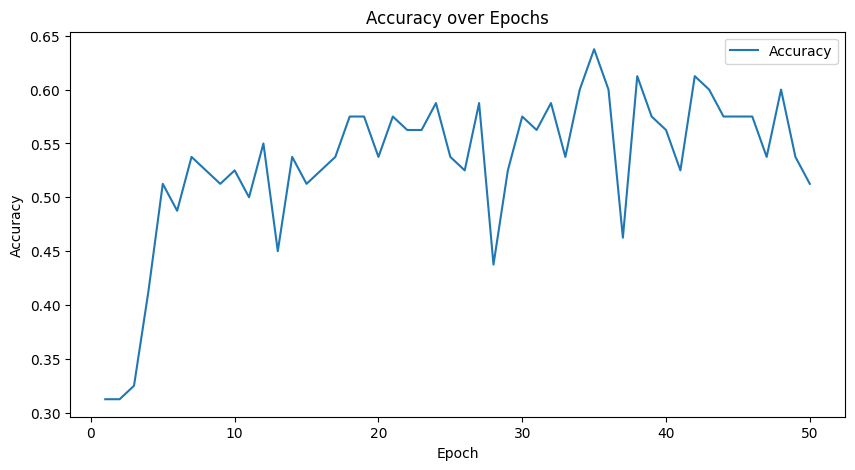

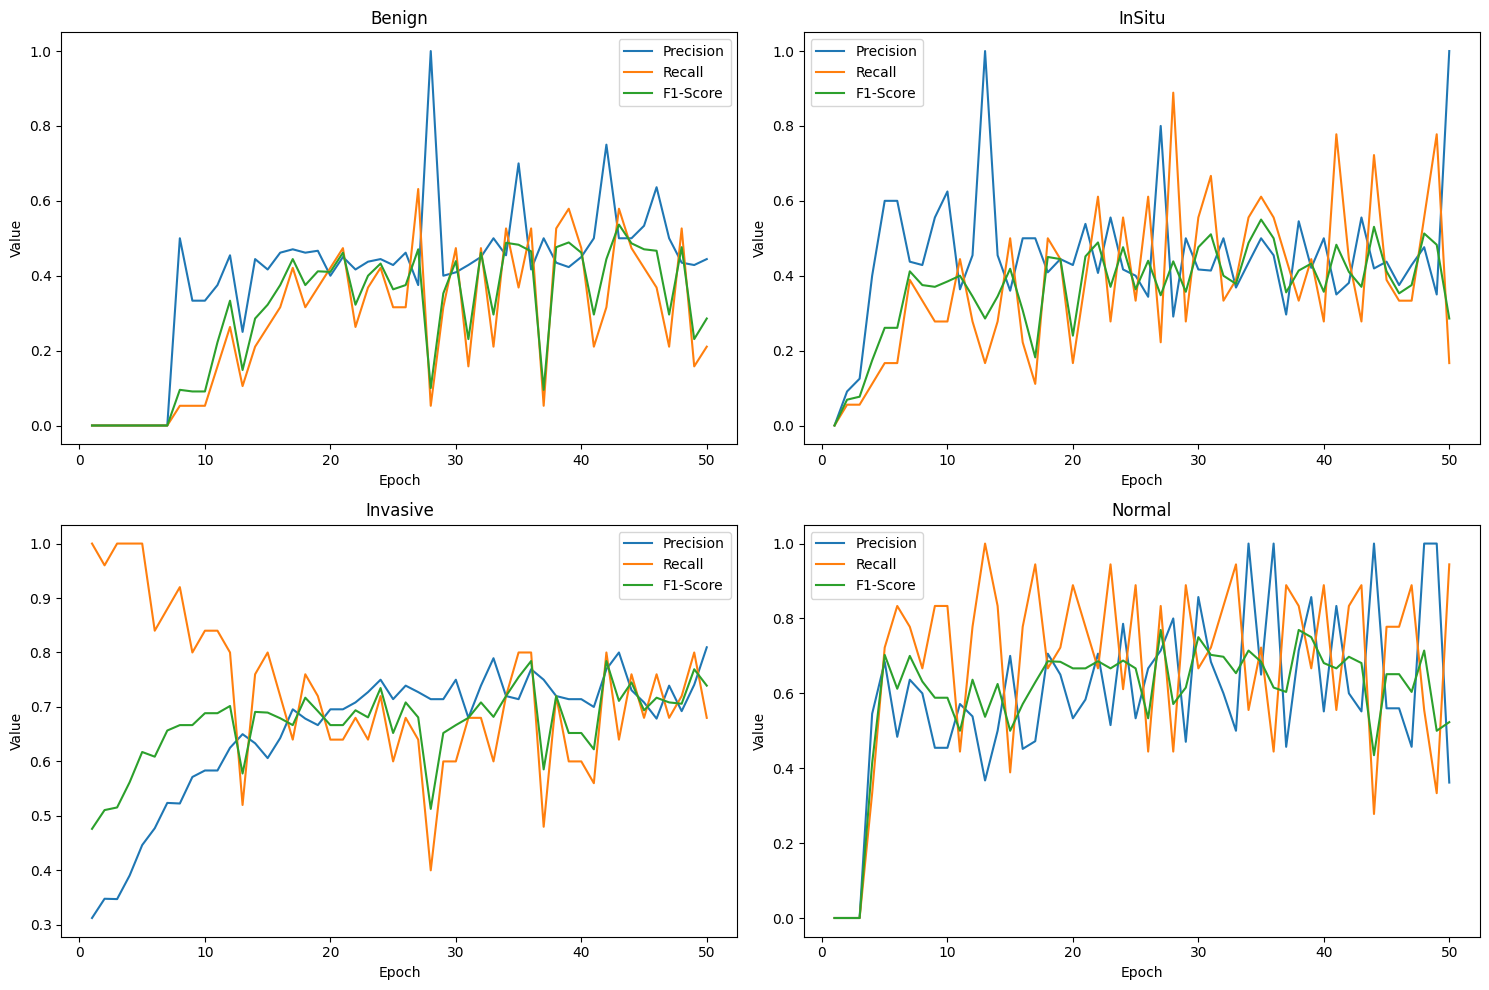

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), accuracy_values, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

# Plot precision, recall, and F1-score for each class
classes = ['Benign', 'InSitu', 'Invasive', 'Normal']
metrics = ['Precision', 'Recall', 'F1-Score']

plt.figure(figsize=(15, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(range(1, num_epochs + 1), precision_values[i], label='Precision')
    plt.plot(range(1, num_epochs + 1), recall_values[i], label='Recall')
    plt.plot(range(1, num_epochs + 1), f1_values[i], label='F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(classes[i])
    plt.legend()

plt.tight_layout()
plt.show()